In [2]:
import pandas as pd
import numpy as np
#from numpy.random import multivariate_normal as normal

In [3]:
from scipy.stats import multivariate_normal as normal
from scipy.stats import norm


In [4]:
# Sample generator
def x_sample_generator(mu, sigma, **args):
    
    n_sample = args.get("n_samples", 1)
    n_dim = args.get("n_dim", 1)
    n_t_intvl = args.get("n_t_intvl", 100)
    total_t = args.get("total_t", 0.5)
    x_init_low = args.get("x_init_low", 70)
    x_init_high = args.get("x_init_high", 170)
    
    d_t = total_t/n_t_intvl
    
    # n_sample==1 or n_dim==1 does not work for normal.rvs (drops a dimension) -- need to reshape 
    dw_sample = normal.rvs(size=[n_sample, n_dim, n_t_intvl]) * np.sqrt(d_t)
    if n_sample==1 or n_dim==1:
        dw_sample = np.reshape(dw_sample, [n_sample, n_dim, n_t_intvl])

    x_sample = np.zeros([n_sample, n_dim, n_t_intvl+1])
    x_sample[:, :, 0] = np.random.uniform(low=x_init_low, high=x_init_high, size=[n_sample, n_dim])

    for i in range(n_t_intvl):
        x_sample[:, :, i+1] = x_sample[:,:,i] * (1 + mu * d_t) + (sigma * x_sample[:,:,i] * dw_sample[:,:,i]) 
    
    return x_sample, dw_sample

In [5]:
# Analytical BlackScholes solution
def black_scholes_analytical(S, T, K, r, sigma, option="call"):

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [70]:
# Genrating samples + plotting black scholes analytical solution for 1 long call option

In [58]:
x = []
u = []
for j in range(50):
    x_s, _ = x_sample_generator(mu=0.06, sigma=0.2, n_t_intvl=100)
    x = x + ([v for v in x_s[0,0,:]])
    for i in range(len(x_s[0,0,:])):
        c_1 = black_scholes_analytical(x_s[:,:,i], 0.5, 120, 0.06, 0.5)[0,0]
        u.append(c_1)

In [59]:
import matplotlib.pyplot as plt

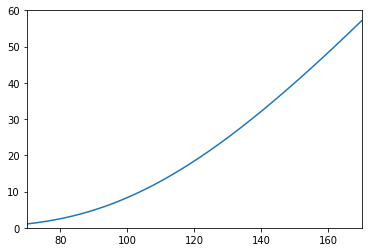

In [64]:
df= pd.DataFrame({"x":x, "u":u})
df=df.sort_values("x")
plt.plot(df.x, df.u)
plt.axis([70,170,0,60])
plt.show()

In [ ]:
# PAYOUT of 1 long + 2 short

In [66]:
payout = df.copy()
payout["long_1"] = 0
payout["short_2"] = 0 
payout["long_1"] = payout["long_1"].where(payout.x < 120, df.x-120, axis=0)
payout["short_2"] = payout["short_2"].where(payout.x < 150, 2 * (150-df.x), axis=0)
payout["y"] = payout["long_1"] + payout["short_2"]

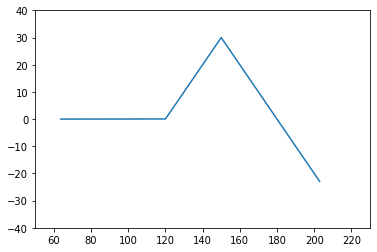

In [69]:
plt.plot(payout.x, payout.y)
plt.axis([50,230,-40,40])
plt.show()

In [62]:
from scipy.interpolate import make_interp_spline

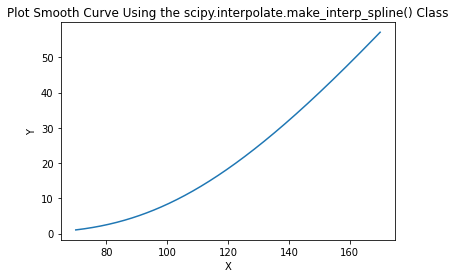

In [63]:
X_Y_Spline = make_interp_spline(df.x, df.u)
X_ = np.linspace(70, 170, 500)
Y_ = X_Y_Spline(X_)
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()